In [8]:
import numpy as np
import xtrack as xt
import xobjects as xo
import xpart as xp
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import constants 


line = xt.Line.from_json('sps.json')
particle_ref=line.particle_ref

line.build_tracker()
#line.freeze_longitudinal()
# line.optimize_for_tracking()

twiss=line.twiss()

clight=constants.speed_of_light
circumference = line.get_length()

#%%
###################
# Linear Transfer #
###################

qx=twiss['qx']
qy=twiss['qy']
dqx=twiss['dqx']
dqy=twiss['dqy']
circumference=twiss['s'][-1]
# beta_x=twiss['betx'][-1]
# beta_y=twiss['bety'][-1]

qs=twiss['qs']
bets=twiss['bets0']


#at interaction points: #from https://anaconda.org/petrenko/li_like_ca_in_sps/notebook
beta_x  =  54.614389 # m
beta_y  =  44.332517 # m
alpha_x = -1.535235
alpha_y =  1.314101



Dx  =  2.444732 # m
Dpx =  0.097522


Dy  =  0.0 # m
Dpy =  0.0

#index of gamma factory along SPS line: 16675

arc = xt.LineSegmentMap(
        qx=qx, qy=qy,
        dqx=0, dqy=0,
        length=circumference,
        alfx=alpha_x,
        alfy=alpha_y,
        betx=beta_x,
        bety=beta_y,
        
        dx=Dx,
        dpx=Dpx,
        dy=Dy,
        dpy=Dpy,
        qs=qs,
        bets=bets,
        )


Loading line from dict:   0%|          | 0/38786 [00:00<?, ?it/s]

Done loading line from dict.           
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [9]:
twiss.keys()

dict_keys(['name', 's', 'x', 'px', 'y', 'py', 'zeta', 'delta', 'ptau', 'W_matrix', 'kin_px', 'kin_py', 'kin_ps', 'kin_xprime', 'kin_yprime', 'betx', 'bety', 'alfx', 'alfy', 'gamx', 'gamy', 'dx', 'dpx', 'dy', 'dpy', 'dx_zeta', 'dpx_zeta', 'dy_zeta', 'dpy_zeta', 'betx1', 'bety1', 'betx2', 'bety2', 'mux', 'muy', 'muzeta', 'nux', 'nuy', 'nuzeta', 'dzeta', 'only_markers', 'particle_on_co', 'circumference', 'orientation', 'R_matrix', 'steps_r_matrix', 'R_matrix_ebe', 'slip_factor', 'momentum_compaction_factor', 'bets0', 'T_rev0', 'gamma0', 'beta0', 'p0c', 'qx', 'qy', 'qs', 'c_minus', 'c_r1_avg', 'c_r2_avg', 'eigenvalues', 'rotation_matrix', 'dmux', 'dmuy', 'bx_chrom', 'by_chrom', 'ax_chrom', 'ay_chrom', 'wx_chrom', 'wy_chrom', 'ddx', 'ddpx', 'ddy', 'ddpy', 'dqx', 'dqy', 'ddqx', 'ddqy', 'values_at', 'method', 'radiation_method', 'reference_frame', 'line_config', '_action'])

In [10]:
from ion_properties import lead,calcium,xenon

ion=calcium

In [11]:
for ion in [lead,calcium,xenon] :# Ion properties:
       
        q0 = ion.q0
        mass0 = ion.mass0

        gamma = ion.gamma_cooling
        beta=  np.sqrt(1-1/(gamma*gamma))
        p0c = mass0*gamma*beta #eV/c

        bunch_intensity = ion.bunch_intensity

        particle_ref = xp.Particles(p0c=p0c, mass0=mass0, q0=q0,gamma0=gamma)

        line.particle_ref=particle_ref


        nemitt = 1.5e-6 # m*rad (normalized emittance)
        sigma_z = ion.bunch_length #m

        emittance=nemitt/(beta*gamma)

        num_particles=int(5e3)

        line_arc=xt.Line(
                elements=[arc])
        line_arc.build_tracker()

        particles = xp.generate_matched_gaussian_bunch(
                num_particles=num_particles,
                total_intensity_particles=bunch_intensity,
                nemitt_x=nemitt, nemitt_y=nemitt, sigma_z=sigma_z,
                particle_ref=particle_ref,
                line=line_arc,        
                )

        particles._init_random_number_generator()

        particles0=particles.copy()
        # sigma_dp=2e-4  
        sigma_dp=np.std(particles.delta)
        print(sigma_dp)
        sigma_dp=2e-4  
        
        ##################
        # Laser Cooler #
        ##################

        #laser-ion beam collision angle
        theta_l = 2.6*np.pi/180 # rad
        nx = 0; ny = -np.sin(theta_l); nz = -np.cos(theta_l)

        # Ion excitation energy:
        ion_excited_lifetime=ion.excited_lifetime
        hw0 = ion.hw0 # eV
        hc=constants.hbar*clight/constants.e # eV*m (ħc)
        lambda_0 = 2*np.pi*hc/hw0 # m -- ion excitation wavelength

        lambda_l = ion.lambda_l

        # # Shift laser wavelength for fast longitudinal cooling:5
        # lambda_l = lambda_l*(1+1*sigma_dp) # m

        laser_frequency = clight/lambda_l # Hz
        sigma_w = 2*np.pi*laser_frequency*sigma_dp
        #sigma_w = 2*np.pi*laser_frequency*sigma_dp/2 # for fast longitudinal cooling

        sigma_t = 1/sigma_w # sec -- Fourier-limited laser pulse
        print('Laser pulse duration sigma_t = %.2f ps' % (sigma_t/1e-12))
        print('Laser wavelength = %.2f nm' % (lambda_l/1e-9))

        laser_waist_radius = 1.3e-3 #m
        laser_energy = 5e-3

        #sigma_t=sigma_t*0.70 # to get 1.9 ps
        # sigma_t=1.9e-12

        GF_IP = xt.PulsedLaser(
                        laser_x=0,
                        laser_y=0,
                        laser_z=0,
                        
                        laser_direction_nx = 0,
                        laser_direction_ny = ny,
                        laser_direction_nz = nz,
                        laser_energy         = laser_energy, # J
                        laser_duration_sigma = sigma_t, # sec
                        laser_wavelength = lambda_l, # m
                        laser_waist_radius = laser_waist_radius, # m
                        laser_waist_shift = 0, # m
                        ion_excitation_energy = hw0, # eV
                        ion_excited_lifetime  = ion_excited_lifetime, # sec                   
                        )

        # simulation parameters: simulate 10 s of cooling, and take data once every 100 ms
        max_time_s = 1
        int_time_s = 0.01
        T_per_turn = circumference/(clight*beta)
        num_turns = int(max_time_s/T_per_turn)
        save_interval = int(int_time_s/T_per_turn)

        # create a monitor object, to reduce holded data
        monitor = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1,
                                n_repetitions=int(num_turns/save_interval),
                                repetition_period=save_interval,
                                num_particles=num_particles)

        line = xt.Line(
                elements=[monitor,GF_IP,arc])

        context = xo.ContextCpu(omp_num_threads=4)
        line.build_tracker(_context=context)


        # line.discard_tracker()
        # IP_index=16675   
        # line.insert_element('monitor', element=monitor, index=IP_index)
        # line.insert_element('GF_IP', element=GF_IP, index=IP_index) #this way monitor comes after the laser
        # SPS_line.append_element(monitor,'monitor')
        # SPS_line.append_element(GF_IP,'GF_IP')
        laser_x_list=np.linspace(-5*1e-3,5*1e-3,150)
        final_emittance_list = []
        final_dp_p=[]
       
       
        transverse_growth_rate_list=[]
        longitudinal_growth_rate_dp_p_list=[]
        longitudinal_growth_rate_emittance_list=[]

       
        from scipy.optimize import curve_fit

        plt.figure(figsize=(12, 8))
        plt.rcParams.update({'font.size': 25})

        for laser_x_loop in tqdm(laser_x_list):
        
                GF_IP.laser_x=laser_x_loop
                particles=particles0.copy()

                # line = xt.Line(
                #         elements=[monitor,GF_IP,arc])

                context = xo.ContextCpu(omp_num_threads=1)
                #line.build_tracker(_context=context)
                # line.optimize_for_tracking()

                line.track(particles, num_turns=num_turns,
                        turn_by_turn_monitor=False,with_progress=True)

                # extract relevant values
                x = monitor.x[:,:,0]
                px = monitor.px[:,:,0]
                y = monitor.y[:,:,0]
                py = monitor.py[:,:,0]
                delta = monitor.delta[:,:,0]
                zeta = monitor.zeta[:,:,0]
                state = monitor.state[:,:,0]
                time = monitor.at_turn[:, 0, 0] * T_per_turn

                gamma_x=(1+alpha_x**2)/beta_x
                gamma_y=(1+alpha_y**2)/beta_y

                action_x = (gamma_x*(x-Dx*delta)**2 + 2*alpha_x*(x-Dx*delta)*(px-Dpx*delta)+ beta_x*(px-Dpx*delta)**2)
                action_y = (gamma_y*(y-Dy*delta)**2 + 2*alpha_y*(y-Dy*delta)*(py-Dpy*delta)+ beta_y*(py-Dpy*delta)**2)

                emittance_x=np.mean(action_x,axis=1)*gamma/2

                 # Calculate mean and standard deviation along the particle axis (axis=1)
                mean_z = np.mean(zeta, axis=1)
                mean_delta = np.mean(delta, axis=1)
                sigma_z = np.std(zeta, axis=1)
                sigma_delta = np.std(delta, axis=1)

                # Calculate the covariance between zeta and delta for each turn
                cov_z_delta = np.mean(zeta * delta, axis=1) - mean_z * mean_delta

                # Calculate longitudinal emittance for each turn
                longitudinal_emittance = np.sqrt(sigma_z**2 * sigma_delta**2 - cov_z_delta**2)

                # Define the exponential function
                def exponential_func(x, a, b):
                        return a * np.exp(x * b)
                
                # Fit the data to the exponential function
                params_transverse, covariance = curve_fit(exponential_func, time, emittance_x)

                # Extract the parameters
                a, b = params_transverse

                transverse_growth_rate_list.append(b)

                final_emittance_list.append(emittance_x[-1])

                # plt.plot(time,emittance_x*1e6, linewidth=5.0)
                # plt.plot(time, exponential_func(time,
                # *params_transverse) * 1e6, linestyle='--')
                
                # Fit the data to the exponential function
                rms_dp_p = np.std(delta, axis=1)
                window_size = 10  # or any other suitable value
                rms_dp_p_smoothed = np.convolve(rms_dp_p, np.ones(window_size)/window_size, mode='valid')
                params_longitudinal_old, covariance = curve_fit(exponential_func, time[:len(rms_dp_p_smoothed)], rms_dp_p_smoothed)
                 # Extract the parameters
                a, b = params_longitudinal_old

                longitudinal_growth_rate_dp_p_list.append(b)


                params_longitudinal, covariance = curve_fit(exponential_func, time, longitudinal_emittance)

                # Extract the parameters
                a, b = params_longitudinal

                longitudinal_growth_rate_emittance_list.append(b)



                final_dp_p.append(rms_dp_p[-1])


        np.savez(f'results/optimal_laser_x/{ion.name}.npz', transverse_growth_rate_list=transverse_growth_rate_list,
                longitudinal_growth_rate_emittance_list=longitudinal_growth_rate_emittance_list,
                longitudinal_growth_rate_dp_p_list=longitudinal_growth_rate_dp_p_list,
                laser_x_list=laser_x_list,nemitt=nemitt,time=time,
                final_dp_p=final_dp_p,final_emittance_list=final_emittance_list)


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
0.00020253718981802363
Laser pulse duration sigma_t = 2.74 ps
Laser wavelength = 1031.80 nm
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


  0%|          | 0/150 [00:00<?, ?it/s]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

  1%|          | 1/150 [00:10<26:36, 10.71s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

  1%|▏         | 2/150 [00:20<25:47, 10.45s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

  2%|▏         | 3/150 [00:32<26:20, 10.75s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

  3%|▎         | 4/150 [00:43<26:21, 10.83s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

  3%|▎         | 5/150 [00:54<26:19, 10.89s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

  4%|▍         | 6/150 [01:03<25:13, 10.51s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

  5%|▍         | 7/150 [01:13<24:46, 10.40s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

  5%|▌         | 8/150 [01:24<24:29, 10.35s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

  6%|▌         | 9/150 [01:34<24:11, 10.30s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

  7%|▋         | 10/150 [01:44<23:38, 10.13s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

  7%|▋         | 11/150 [01:53<23:05,  9.97s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

  8%|▊         | 12/150 [02:03<22:40,  9.86s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

  9%|▊         | 13/150 [02:12<22:18,  9.77s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

  9%|▉         | 14/150 [02:22<22:16,  9.82s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 10%|█         | 15/150 [02:32<22:08,  9.84s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 11%|█         | 16/150 [02:42<22:14,  9.96s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 11%|█▏        | 17/150 [02:52<22:05,  9.97s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 12%|█▏        | 18/150 [03:02<21:55,  9.97s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 13%|█▎        | 19/150 [03:13<21:59, 10.08s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 13%|█▎        | 20/150 [03:23<22:08, 10.22s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 14%|█▍        | 21/150 [03:34<22:27, 10.45s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 15%|█▍        | 22/150 [03:45<22:17, 10.45s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 15%|█▌        | 23/150 [03:55<22:08, 10.46s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 16%|█▌        | 24/150 [04:06<22:08, 10.54s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 17%|█▋        | 25/150 [04:17<22:26, 10.77s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 17%|█▋        | 26/150 [04:28<22:29, 10.88s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 18%|█▊        | 27/150 [04:39<22:08, 10.80s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 19%|█▊        | 28/150 [04:50<21:57, 10.80s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 19%|█▉        | 29/150 [05:00<21:41, 10.76s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 20%|██        | 30/150 [05:11<21:23, 10.70s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 21%|██        | 31/150 [05:22<21:14, 10.71s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 21%|██▏       | 32/150 [05:33<21:11, 10.78s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 22%|██▏       | 33/150 [05:44<21:14, 10.89s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 23%|██▎       | 34/150 [05:55<21:07, 10.93s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 23%|██▎       | 35/150 [06:06<21:01, 10.97s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 24%|██▍       | 36/150 [06:17<20:50, 10.97s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 25%|██▍       | 37/150 [06:28<20:50, 11.06s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 25%|██▌       | 38/150 [06:39<20:36, 11.04s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 26%|██▌       | 39/150 [06:50<20:30, 11.08s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 27%|██▋       | 40/150 [07:01<20:18, 11.08s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 27%|██▋       | 41/150 [07:13<20:13, 11.13s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 28%|██▊       | 42/150 [07:24<20:19, 11.30s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 29%|██▊       | 43/150 [07:36<20:10, 11.31s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 29%|██▉       | 44/150 [07:47<19:54, 11.27s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 30%|███       | 45/150 [07:59<20:02, 11.45s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 31%|███       | 46/150 [08:11<20:03, 11.57s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 31%|███▏      | 47/150 [08:23<20:22, 11.87s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 32%|███▏      | 48/150 [08:35<20:05, 11.82s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 33%|███▎      | 49/150 [08:47<20:00, 11.89s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 33%|███▎      | 50/150 [08:59<19:57, 11.97s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 34%|███▍      | 51/150 [09:11<19:54, 12.06s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 35%|███▍      | 52/150 [09:23<19:24, 11.89s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 35%|███▌      | 53/150 [09:34<18:59, 11.75s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 36%|███▌      | 54/150 [09:46<18:55, 11.83s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 37%|███▋      | 55/150 [09:58<18:47, 11.86s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

 37%|███▋      | 56/150 [10:09<18:08, 11.58s/it]

Tracking:   0%|          | 0/43400 [00:00<?, ?it/s]

Transverse emittance

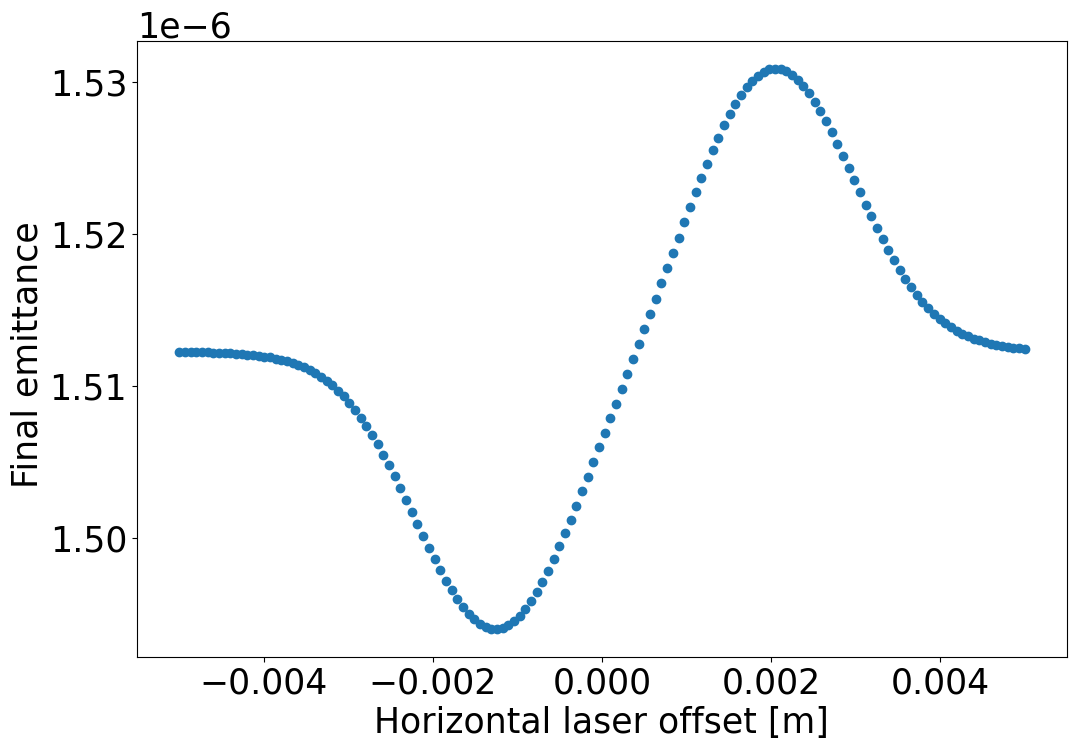

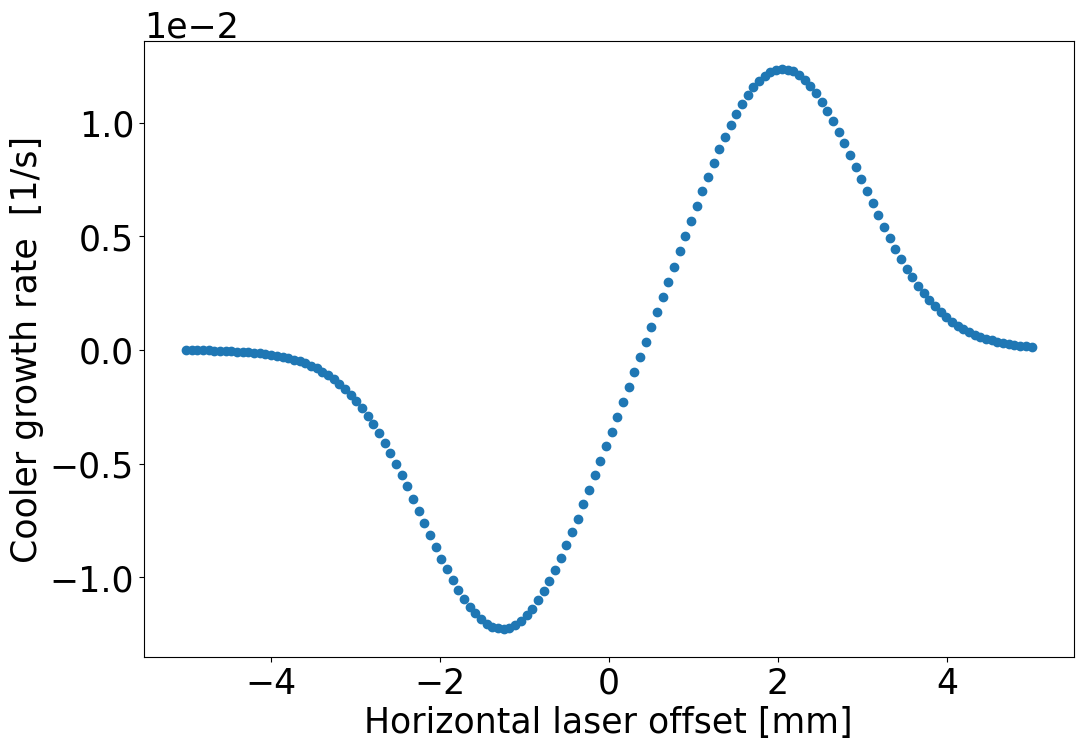

In [ ]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.scatter(laser_x_list,final_emittance_list)
plt.xlabel('Horizontal laser offset [m]')
plt.ylabel('Final emittance ')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.scatter(laser_x_list*1e3,transverse_growth_rate_list)
plt.xlabel('Horizontal laser offset [mm]')
plt.ylabel('Cooler growth rate  [1/s]')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.savefig('Optimal_laser_offset.png',dpi=300)
plt.show()



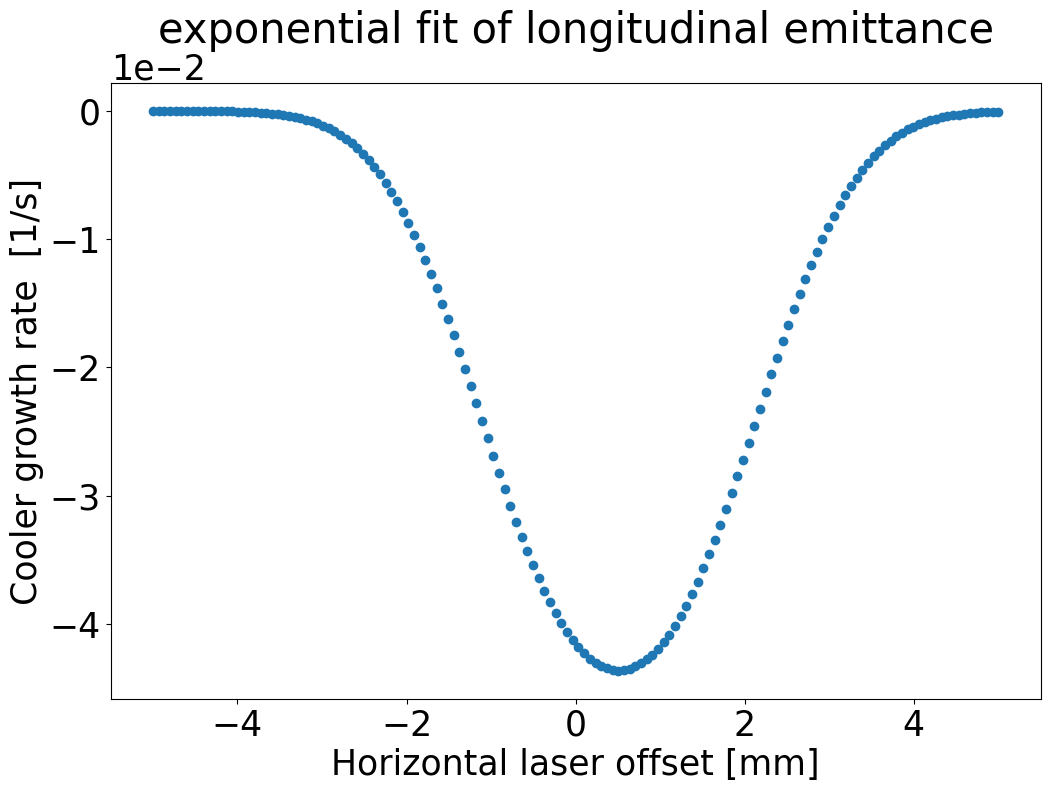

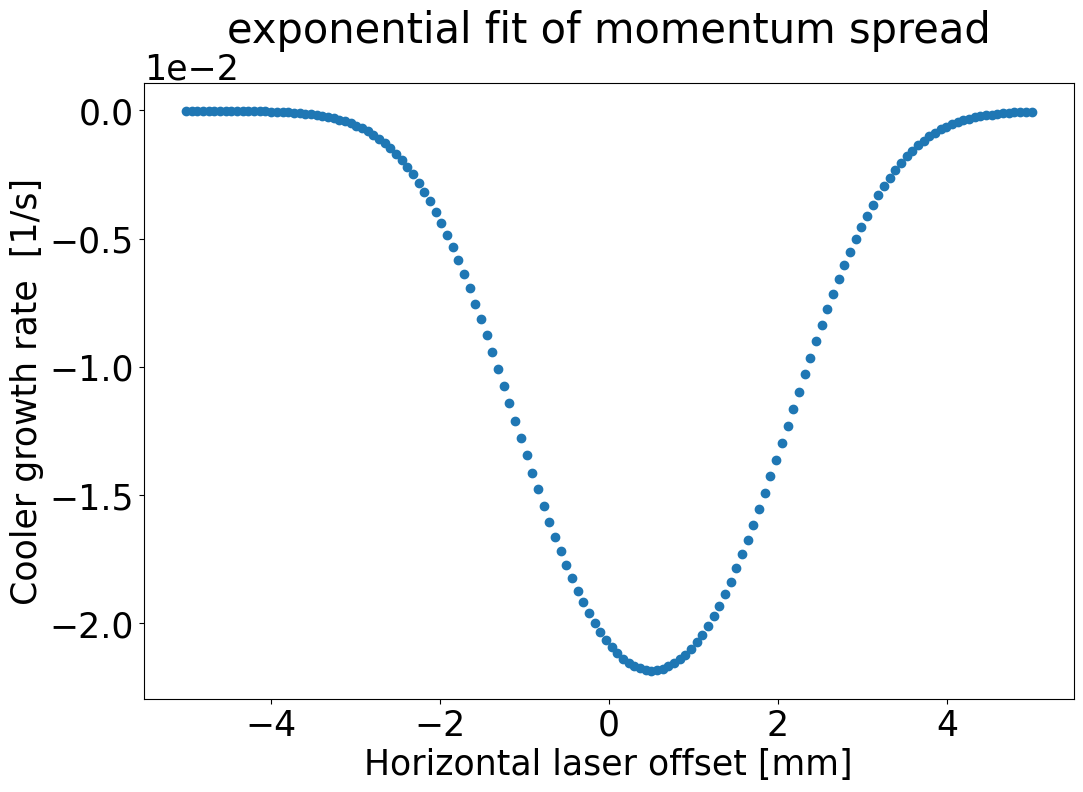

In [ ]:
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title('exponential fit of longitudinal emittance')
plt.scatter(laser_x_list*1e3,longitudinal_growth_rate_emittance_list)
plt.xlabel('Horizontal laser offset [mm]')
plt.ylabel('Cooler growth rate  [1/s]')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.savefig('Optimal_laser_offset.png',dpi=300)
plt.show()

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 25})
plt.title('exponential fit of momentum spread')
plt.scatter(laser_x_list*1e3,longitudinal_growth_rate_dp_p_list)
plt.xlabel('Horizontal laser offset [mm]')
plt.ylabel('Cooler growth rate  [1/s]')
ax = plt.gca()
# Removing the offset from the y-axis tick labels
ax.yaxis.get_major_formatter().set_useOffset(False)
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
# plt.savefig('Optimal_laser_offset.png',dpi=300)
plt.show()